In [ ]:
# MIT License
#
#@title Copyright (c) 2021 CCAI Community Authors { display-mode: "form" }
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [ ]:
#作業ディレクトリの設定
import os
os.chdir("..")
os.chdir("..")
os.getcwd()

## 1. 学習済みモデル（力場）のダウンロード

学習済みのモデルを右記リンクからダウンロードします。[here](https://github.com/Open-Catalyst-Project/ocp/blob/master/MODELS.md)学習済みのモデルはASEのCalculatorクラスとして使用できます。

In [ ]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import LBFGS
from ase.build import fcc100, fcc111, add_adsorbate, molecule
import os
from ase.constraints import FixAtoms
import numpy as np
from ase.io import extxyz
from ase.data import atomic_numbers

import ase
from ase import Atoms, units, Atom
from ase.units import Bohr,Rydberg,kJ,kB,fs,Hartree,mol,kcal
from ase.io import read, write
from ase.build import surface, molecule, add_adsorbate
from ase.constraints import FixAtoms, FixedPlane, FixBondLength, ExpCellFilter
from ase.neb import NEB
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.optimize import BFGS, LBFGS, FIRE
from ase.md import MDLogger
from ase.io import read, write, Trajectory
from ase.build import sort
import pandas as pd
from ase.build import bulk

#モデルの置き場所（絶対パスで指定）
checkpoint_path = "C:/Users/****/ocp/gnoc_oc22_oc20_all_s2ef.pt"
config_yml_path = r"C:\Users\****\ocp\configs\oc22\s2ef\gemnet-oc\gemnet_oc_oc20_oc22.yml"

#Define the calculator
calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path, cpu = False)

## 2. ベース構造の読込  

まずはベースとなる構造、すなわちCの吸着した触媒構造を読み込みます。計算量が膨大になっても仕方がないので、ここでは「Cの吸着による利得が最も大きかった構造」をベースとします。なお、確認のためこれらの構造については一度viewerで破綻していないかを見ておきます。

In [ ]:
df_base = pd.read_csv("./20230801_CO_dissociation_on_metal/Outputs/20230802_ads_energy_CO_decomposition.csv")
df_base_CO = df_base[df_base["mol"] == "C"]
df_base_CO

In [ ]:
#最安定の吸着構造（手動で読込）
Co_C = read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co(1_1_1)31C.cif")

In [ ]:
view(Co_C)

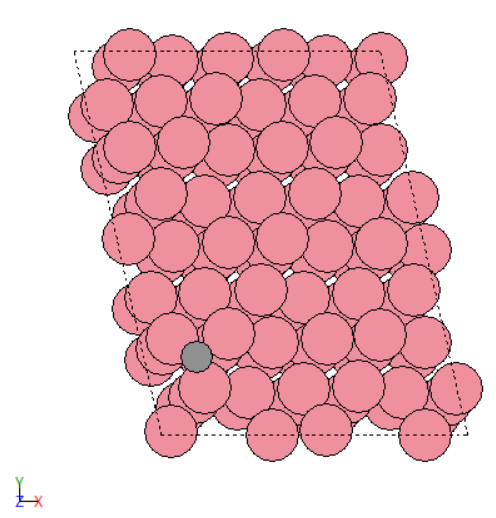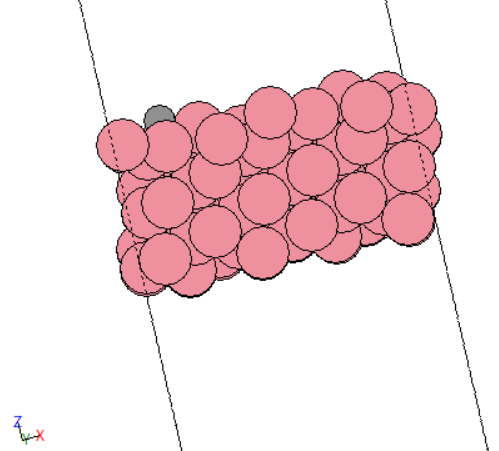

## 3. C-O乖離構造の最適化

我々がやりたいのは、COの乖離反応におけるエンタルピー差を計算することです。今我々はCOの吸着構造と、そのエネルギーを知っています（adsorptin_structure_analysis.ipynbより）。一方で、CとOが乖離して吸着した構造の最適化は済んでいませんので、これを作成する必要があります。  

C-Oが乖離吸着した構造の最適化は、先ほど読み込んだベース構造（Co上にCが吸着した構造）に対し「どこにOを付けると最も安定か」という問題に置き換えることができます（勿論、Cも固定しないに越したことはないのですが、計算量は増えます。興味あればこのスクリプトを応用してやってみて下さい）。この問題を効率的に解くため、ここではOptunaというパッケージを使用します。

In [ ]:
#インストール未であれば下記pipコマンドを実行（#を消すと有効になります）、2回目以降は#でコメントアウトしてください
#pip install optuna
import optuna

Optunaは非常に強力な最適化アルゴリズムの一つです。最適化というのは、例えば下記例で言えば2次関数の最小値（や最大値、任意の値）を求めることを指します。2次関数であればどこが最適かどうかを我々は公式に従って求めることができます（解析的に求める、と言います）が、複雑な最適化問題になると解析的に最適点を求める、というのは難しくなります（今回のように、Cが吸着した構造のどこにOを追加すべきか、というような問題）。こうした場合には、何回も計算を試行して最適な値を探索する、という方法がとられます。Optunaはこの探索をきわめて高速かつ効率的にこなすことができるので、現在では広く使用されています。  
※引用元：https://optuna.org/

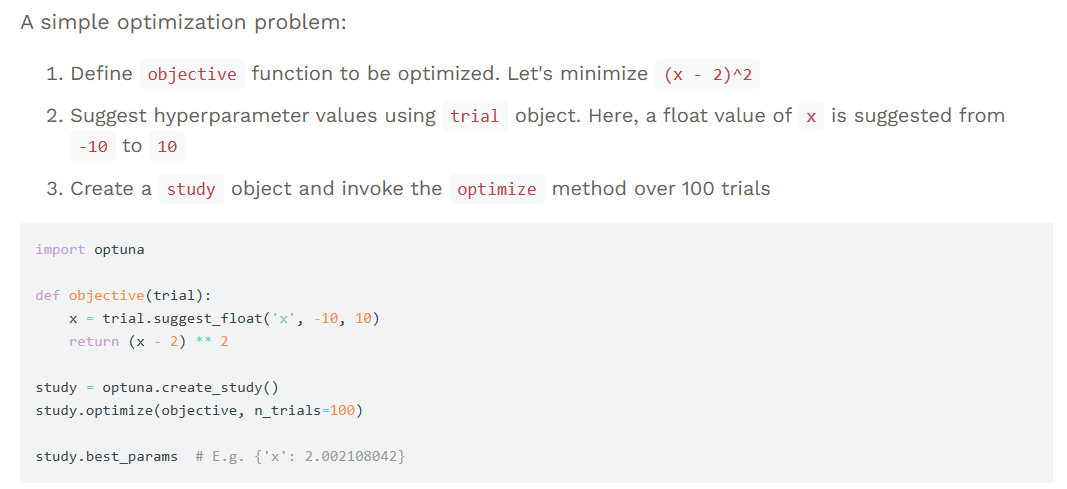

In [ ]:
# Cの座標を取得する
ads_position = [atom.position for atom in Co_C if atom.symbol == 'C']
ads_position

In [ ]:
import random

# 吸着している分子の位置
adsorbate_positions = ads_position

# 分子同士の最小距離（適宜修正）
min_distance = 2.0

#Oを付ける位置がCに近すぎた場合を検知する関数
def is_too_close(pos, other_positions):
    for other_pos in other_positions:
        distance = np.linalg.norm(np.array(pos[:2]) - np.array(other_pos[:2]))
        if distance < min_distance:
            return True
    return False

#Oをランダムに吸着させて、エネルギーを求める関数
def place_h_randomly(mol_on_slab, trial):
    h_atom = Atoms('O')

    for _ in range(trial.number):
        # スラブの範囲内に配置
        h_atom.x = trial.suggest_uniform('x', 0, slab_width)
        h_atom.y = trial.suggest_uniform('y', 0, slab_length)
        h_atom.z = 0

        # 吸着している分子の周囲を考慮してH原子の配置を試行
        if not is_too_close((h_atom.x, h_atom.y, h_atom.z), adsorbate_positions):
            break
    else:
        raise optuna.TrialPruned()

    # mol_on_slabにHを結合
    add_adsorbate(mol_on_slab, h_atom, height=1, position=(h_atom.x, h_atom.y))
    
    # tag all slab atoms below surface as 0, surface as 1
    tags = np.zeros(len(mol_on_slab))
    #マジックナンバーだらけになっているので他の用途に供する際は注意（もう一つのnotebookと合わせた条件をC + Oにも適用した）
    tags[round((len(mol_on_slab) - 2)*0.8) + 2:len(mol_on_slab)] = 1
    mol_on_slab.set_tags(tags)
    # Fixed atoms are prevented from moving during a structure relaxation. 
    # We fix all slab atoms beneath the surface. 
    cons= FixAtoms(indices=[atom.index for atom in mol_on_slab if (atom.tag == 0)])
    mol_on_slab.set_constraint(cons)
    mol_on_slab.set_calculator(calc)

    # 最適化（吸着点の探索なので、あくまでも少しだけ）
    dyn = LBFGS(mol_on_slab)
    dyn.run(fmax=0.05, steps = 10)

    # エネルギーを計算して報酬とする
    energy = mol_on_slab.get_potential_energy()
    return energy

Optunaを用いて実際に最適化問題を解いていきます。30回探索して、一番エネルギーの低いOの吸着点を探しましょう。

In [ ]:
# スラブの大きさを適切に設定（適宜修正）
slab_width = 10.0
slab_length = 10.0

# Optunaによる最適化
def objective(trial):
    mol_on_slab = Co_C.copy()    
    energy = place_h_randomly(mol_on_slab, trial)
    
    del mol_on_slab
    return energy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# 最適なパラメータを表示
best_params = study.best_params
print("Best Parameters:", best_params)

最適と判断された吸着点にOを吸着させ、構造最適化を行います。

In [ ]:
mol_on_slab = Co_C.copy()

h_atom = Atoms('O')
# mol_on_slabにHを結合
add_adsorbate(mol_on_slab, h_atom, height=1, position=(best_params["x"], best_params["y"]))

# tag all slab atoms below surface as 0, surface as 1
tags = np.zeros(len(mol_on_slab))
#マジックナンバーだらけになっているので他の用途に供する際は注意（もう一つのnotebookと合わせた条件をC + Oにも適用した）
tags[round((len(mol_on_slab) - 2)*0.8) + 2:len(mol_on_slab)] = 1
mol_on_slab.set_tags(tags)
# Fixed atoms are prevented from moving during a structure relaxation. 
# We fix all slab atoms beneath the surface. 
cons= FixAtoms(indices=[atom.index for atom in mol_on_slab if (atom.tag == 0)])
mol_on_slab.set_constraint(cons)
mol_on_slab.set_calculator(calc)

# 最適化（吸着点の探索なので、あくまでも少しだけ）
dyn = FIRE(mol_on_slab)
dyn.run(fmax=0.05, steps = 100)

# エネルギーを計算して報酬とする
C_O_energy = mol_on_slab.get_potential_energy() + 0.8
ase.io.write("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co(1_1_1)31C_O.cif", mol_on_slab, format='cif')


In [ ]:
#構造の確認
view(mol_on_slab)

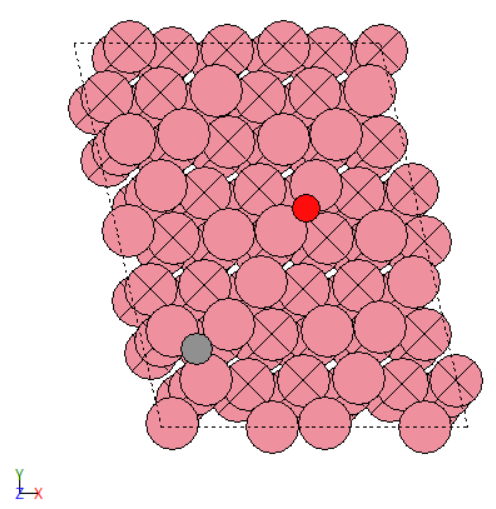

In [ ]:
from ase import Atoms
from ase.build import fcc111

# レイヤー数を測定する関数
def measure_layer_number(slab, threshold):
    # z座標を基準に昇順にソート
    sorted_indices = sorted(range(len(slab)), key=lambda i: slab.positions[i, 2])

    # レイヤーの境界を検出
    layer_boundaries = [0]
    current_z = slab.positions[sorted_indices[0], 2]
    for i in sorted_indices:
        if abs(slab.positions[i, 2] - current_z) > threshold:
            layer_boundaries.append(i)
            current_z = slab.positions[i, 2]
    layer_boundaries.append(len(slab))

    # レイヤー数を計算
    layer_number = len(layer_boundaries) - 1

    return layer_number


In [ ]:
Co_slab = read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/slab_opt/Co(1_1_1).cif")
baisu = round(8/(len(Co_slab)/measure_layer_number(Co_slab, 1)))

if len(Co_slab) <= 50:
    Co_slab = Co_slab * (baisu, baisu, 1)

# tag all slab atoms below surface as 0, surface as 1
tags = np.zeros(len(Co_slab))
#マジックナンバーだらけになっているので他の用途に供する際は注意（もう一つのnotebookと合わせた条件を適用した）
tags[round((len(Co_slab))*0.8):len(Co_slab)] = 1
Co_slab.set_tags(tags)
# Fixed atoms are prevented from moving during a structure relaxation. 
# We fix all slab atoms beneath the surface. 
cons= FixAtoms(indices=[atom.index for atom in Co_slab if (atom.tag == 0)])
Co_slab.set_constraint(cons)
Co_slab.set_calculator(calc)

#1.25はgas reference energy
Co_slab_E = Co_slab.get_potential_energy()
Co_slab_E

乖離前後のエンタルピー変化（それぞれの吸着エネルギー差）を算出します。こちらの計算では、0.32 eVという結果が出ました。

In [ ]:
#最適化されたCとOの吸着構造とCOの吸着構造のエネルギー差を算出（17.03...はCo上のCO吸着エネルギー最小値）
C_O_energy - Co_slab_E + 17.039563

## Co-V表面におけるC, Oの吸着構造とエネルギー差  

Co-Vについても同様の計算を実施します。

In [ ]:
df_base_sub = pd.read_csv("./20230801_CO_dissociation_on_metal/Outputs/20230802_ads_energy_CO_decomposition_sub.csv")
df_base_CO_sub = df_base_sub[df_base_sub["mol"] == "CO"]
df_base_CO_sub

In [ ]:
Co_V_C = read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co59V5Co(1_1_1)32C.cif")

In [ ]:
view(Co_V_C)

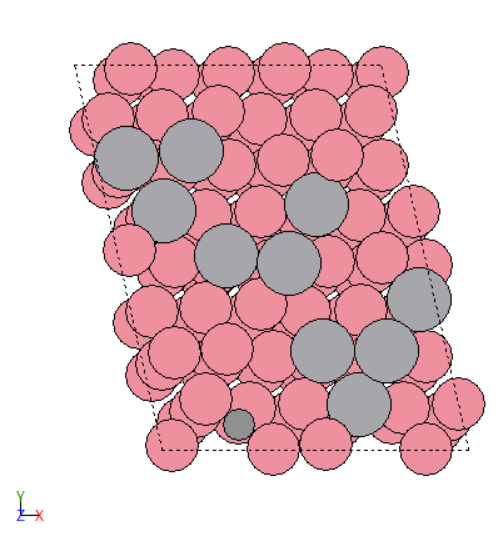

In [ ]:
# Cの座標を取得する
ads_position = [atom.position for atom in Co_V_C if atom.symbol == 'C']
ads_position

# スラブの大きさを適切に設定（適宜修正）
slab_width = 10.0
slab_length = 10.0

# Optunaによる最適化
def objective(trial):
    mol_on_slab = Co_V_C.copy()    
    energy = place_h_randomly(mol_on_slab, trial)
    
    del mol_on_slab
    return energy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# 最適なパラメータを表示
best_params = study.best_params
print("Best Parameters:", best_params)

In [ ]:
mol_on_slab = Co_V_C.copy()

h_atom = Atoms('O')
# mol_on_slabにHを結合
add_adsorbate(mol_on_slab, h_atom, height=1, position=(best_params["x"], best_params["y"]))

# tag all slab atoms below surface as 0, surface as 1
tags = np.zeros(len(mol_on_slab))
#マジックナンバーだらけになっているので他の用途に供する際は注意（もう一つのnotebookと合わせた条件をC + Oにも適用した）
tags[round((len(mol_on_slab) - 2)*0.8) + 2:len(mol_on_slab)] = 1
mol_on_slab.set_tags(tags)
# Fixed atoms are prevented from moving during a structure relaxation. 
# We fix all slab atoms beneath the surface. 
cons= FixAtoms(indices=[atom.index for atom in mol_on_slab if (atom.tag == 0)])
mol_on_slab.set_constraint(cons)
mol_on_slab.set_calculator(calc)

# 最適化（吸着点の探索なので、あくまでも少しだけ）
dyn = FIRE(mol_on_slab)
dyn.run(fmax=0.05, steps = 100)

# エネルギーを計算して報酬とする
C_O_energy = mol_on_slab.get_potential_energy()
ase.io.write("./20230801_CO_dissociation_on_metal/Outputs/support/Co/mol_on_slab_opt/Co59V5Co(1_1_1)32C_O.cif", mol_on_slab, format='cif')


In [ ]:
#構造の確認
view(mol_on_slab)

最適と判断された吸着構造を確認します。OがVと相互作用する吸着点が安定となることが示唆されました。

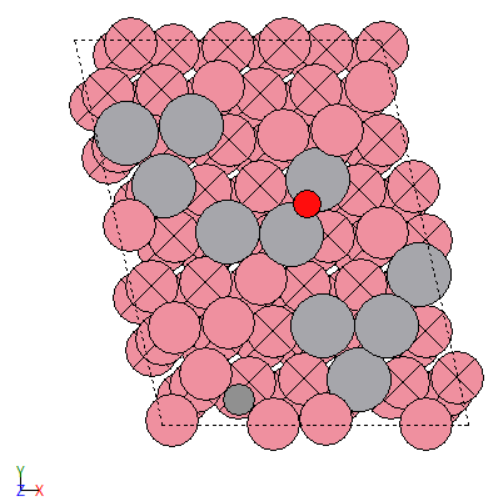

In [ ]:
Co_V_slab = read("./20230801_CO_dissociation_on_metal/Outputs/support/Co/slab_opt/Co59V5Co(1_1_1).cif")
baisu = round(8/(len(Co_V_slab)/measure_layer_number(Co_V_slab, 1)))

if len(Co_V_slab) <= 50:
    Co_V_slab = Co_V_slab * (baisu, baisu, 1)

# tag all slab atoms below surface as 0, surface as 1
tags = np.zeros(len(Co_V_slab))
#マジックナンバーだらけになっているので他の用途に供する際は注意（もう一つのnotebookと合わせた条件を適用した）
tags[round((len(Co_V_slab))*0.8):len(Co_V_slab)] = 1
Co_V_slab.set_tags(tags)
# Fixed atoms are prevented from moving during a structure relaxation. 
# We fix all slab atoms beneath the surface. 
cons= FixAtoms(indices=[atom.index for atom in Co_V_slab if (atom.tag == 0)])
Co_V_slab.set_constraint(cons)
Co_V_slab.set_calculator(calc)

#1.25はgas reference energy
Co_V_slab_E = Co_V_slab.get_potential_energy() + 0.8
Co_V_slab_E

Co-Vについても、乖離前後のエンタルピー変化を算出します。結果は-1.66 eVとなり、Co単体に比して乖離後の構造が安定化された（BEP則より、活性化エネルギーが低下した）ことが分かりました。また吸着構造を可視化することにより、生じたOがVと相互作用することが、安定化要因であることが示唆されました。

In [ ]:
#最適化されたCとOの吸着構造とCOの吸着構造のエネルギー差を算出（-16.94...はCo-V上におけるCO吸着エネルギーの最小値）
C_O_energy - Co_V_slab_E + 16.947949